In [4]:
%load_ext autoreload
%autoreload 2

In [39]:
import os
import sys

import autograd.numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation

import seaborn as sns

from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

# Evaluation Pipeline

## Fitness Function

In [25]:
f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

In [26]:
xmin, xmax, xstep = -4.5, 4.5, 0.2
ymin, ymax, ystep = -4.5, 4.5, 0.2

X, Y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep),
                   np.arange(ymin, ymax + ystep, ystep))

Z = f(X, Y)

In [27]:
minima = np.array([3.0, 0.5])

f(*minima)

0.0

In [28]:
minima_ = minima.reshape(-1, 1)
minima_

array([[3. ],
       [0.5]])

In [29]:
f(*minima_)

array([0.])

## 3D Surface Plot 

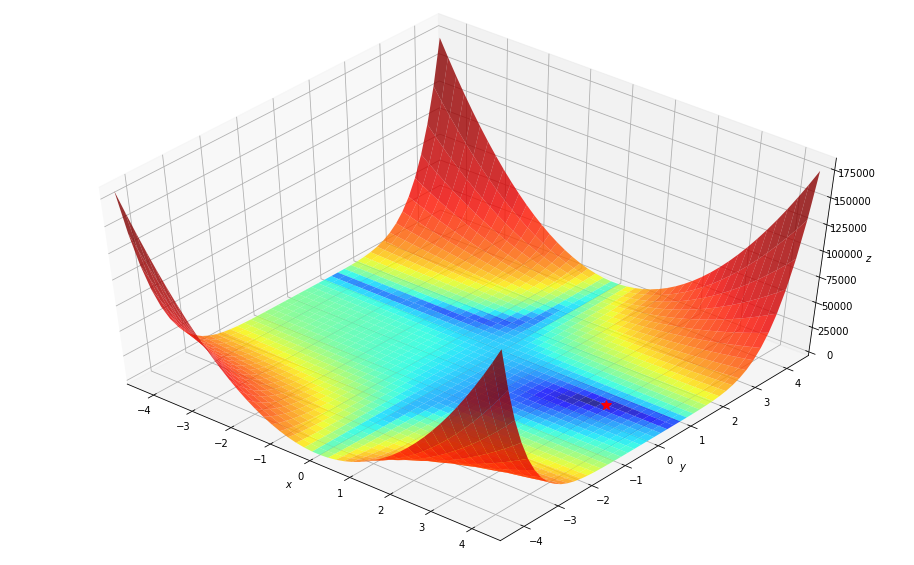

In [67]:
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(X, Y, Z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)

ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

## 2D Gradient Vector Field 

In [33]:
δz_δx = elementwise_grad(f, argnum=0)(X, Y)
δz_δy = elementwise_grad(f, argnum=1)(X, Y)

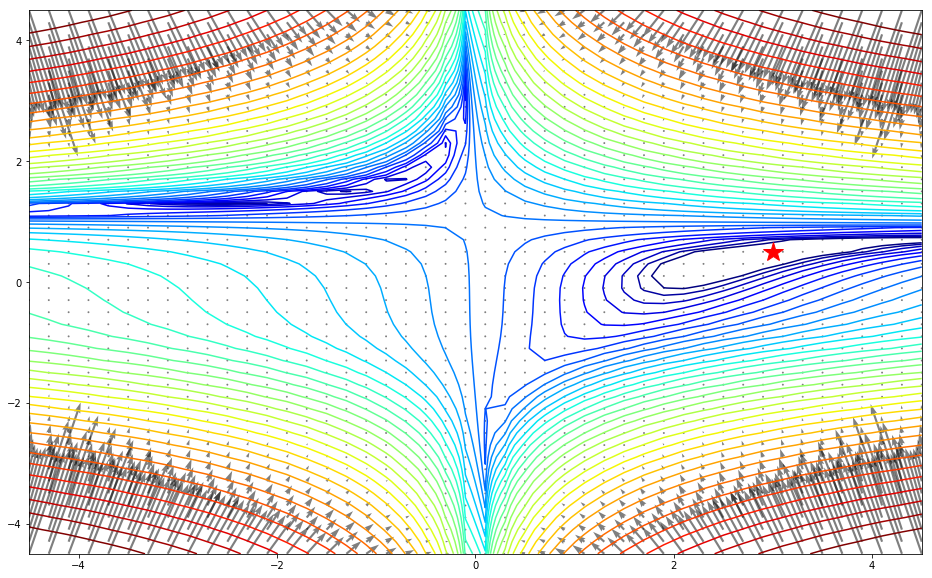

In [47]:
fig, axes = plt.subplots(figsize=(16, 10))

axes.contour(X, Y, Z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
axes.quiver(X, Y, X - δz_δx, Y - δz_δy, alpha=0.5)
axes.plot(*minima_, 'r*', markersize=20)

plt.show()

## Gradient-based Optimisation 

In [50]:
X_0 = np.array([3.0, 4.0])

func = value_and_grad(lambda args: f(*args))

In [51]:
results = minimize(func, x0=X_0, method='Newton-CG', jac=True, tol=1e-20, callback=print)

[2.71113991 3.35161828]
[2.48008912 2.78955116]
[2.29965866 2.30123678]
[2.16373347 1.8756312 ]
[2.06741079 1.50235414]
[2.00766238 1.17079384]
[1.98485905 0.86972447]
[2.00511126 0.59071489]
[2.07692544 0.34891823]
[2.17857778 0.21644485]
[2.55966682 0.38003383]
[2.80228089 0.44954972]
[2.94477854 0.48765376]
[2.94564749 0.48601427]
[2.95359059 0.48810805]
[2.97113927 0.49269804]
[2.99870879 0.49976069]
[2.99999481 0.49999876]
[3.00000001 0.49999999]
[3.  0.5]
[3.  0.5]


In [52]:
results

     fun: 2.5770606809684326e-18
     jac: array([8.13600382e-10, 1.86117137e-09])
 message: 'Optimization terminated successfully.'
    nfev: 22
    nhev: 0
     nit: 21
    njev: 104
  status: 0
 success: True
       x: array([3. , 0.5])

In [53]:
def make_minimize_callback(path=[]):
    def minimize_callback(X_i):
        path.append(np.copy(X_i))
        
    return minimize_callback

In [54]:
path_ = [X_0]

results = minimize(func, x0=X_0, method='Newton-CG',
                   jac=True, tol=1e-20, callback=make_minimize_callback(path_))

In [55]:
results

     fun: 2.5770606809684326e-18
     jac: array([8.13600382e-10, 1.86117137e-09])
 message: 'Optimization terminated successfully.'
    nfev: 22
    nhev: 0
     nit: 21
    njev: 104
  status: 0
 success: True
       x: array([3. , 0.5])

In [56]:
path = np.array(path_).T
path.shape

(2, 22)

In [57]:
path

array([[3.        , 2.71113991, 2.48008912, 2.29965866, 2.16373347,
        2.06741079, 2.00766238, 1.98485905, 2.00511126, 2.07692544,
        2.17857778, 2.55966682, 2.80228089, 2.94477854, 2.94564749,
        2.95359059, 2.97113927, 2.99870879, 2.99999481, 3.00000001,
        3.        , 3.        ],
       [4.        , 3.35161828, 2.78955116, 2.30123678, 1.8756312 ,
        1.50235414, 1.17079384, 0.86972447, 0.59071489, 0.34891823,
        0.21644485, 0.38003383, 0.44954972, 0.48765376, 0.48601427,
        0.48810805, 0.49269804, 0.49976069, 0.49999876, 0.49999999,
        0.5       , 0.5       ]])

## Static Quiver Plot of Path on 2D Contour Plot 

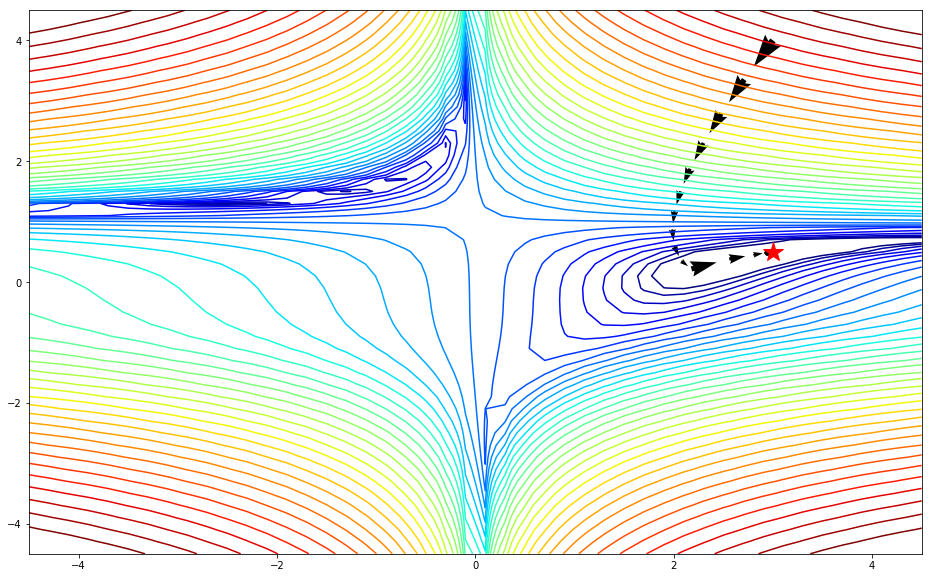

In [68]:
fig, axes = plt.subplots(figsize=(16, 10))

axes.contour(X, Y, Z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
axes.quiver(path[0, :-1], path[1, :-1], path[0, 1:] - path[0, :-1], path[1, 1:] - path[1, :-1],
            scale_units='xy', angles='xy', scale=1.5, color='k')
axes.plot(*minima_, 'r*', markersize=20)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

## Static Plot of Path on 3D Surface Plot 

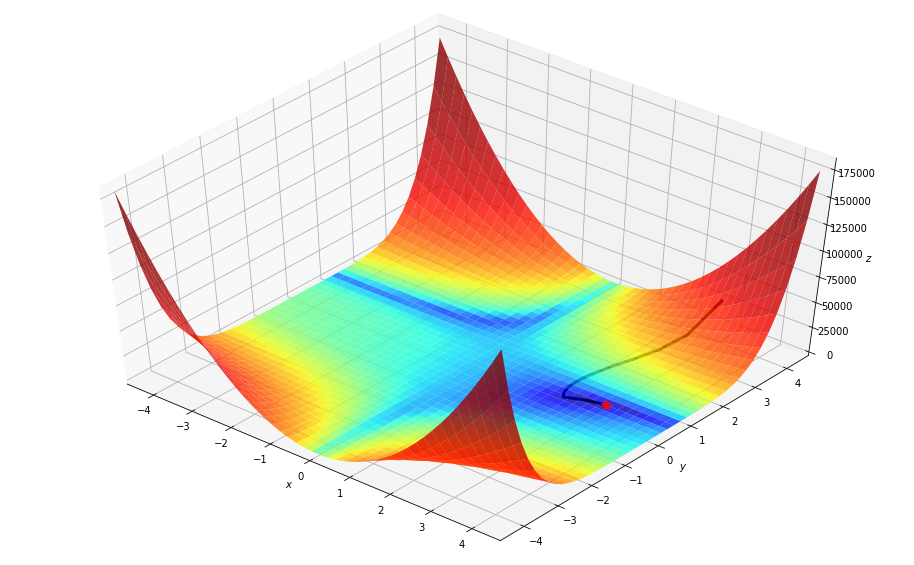

In [97]:
fig = plt.figure(figsize=(16, 10))

ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(X, Y, Z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.8, cmap=plt.cm.jet)

ax.plot_wireframe(path[0, :-1], path[1, :-1], f(*path[:, :-1]), linewidths=3, colors='k')

ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

## Animated Single Path on 2D Contour Plot 

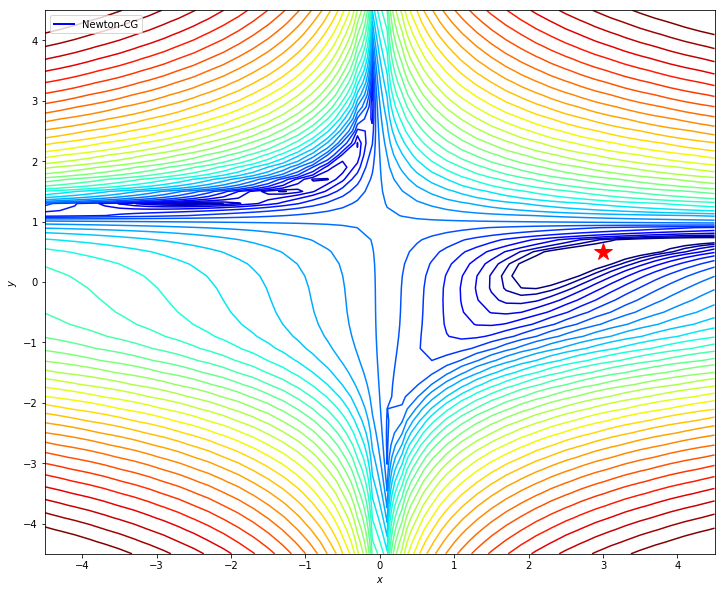

In [108]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.contour(X, Y, Z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima_, 'r*', markersize=18)

line, = ax.plot([], [], 'b', label='Newton-CG', lw=2)
point, = ax.plot([], [], 'bo')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

ax.legend(loc='upper left')
plt.show()

In [109]:
def init():
    line.set_data([], [])
    point.set_data([], [])
    return line, point

def animate(i):
    line.set_data(*path[:, :i])
    point.set_data(*path[:, i-1:i])
    return line, point

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=path.shape[1], interval=60, repeat_delay=5, blit=True)

In [110]:
HTML(anim.to_html5_video())